In [7]:
# Importing Packages
import mne
import numpy as np
import pandas as pd
import neurokit2 as nk
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

Below are a few samples from the Neurokit2 publication Github demonstrating EMG, EOG, and ECG processing and visualization. Our project uses their EEG functions instead of ECG.

Sample #1 (EMG)

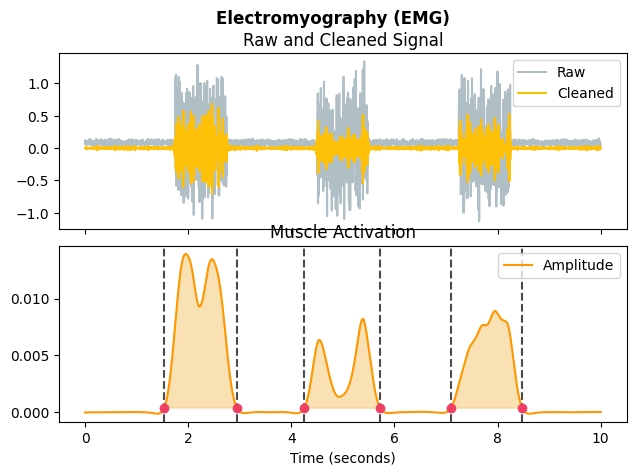

In [8]:
# Generate 10 seconds of EMG signal (recorded at 250 samples/second)
samp_emg = nk.emg_simulate(duration=10, sampling_rate=250, burst_number=3)

# Process it
samp_signals, samp_info = nk.emg_process(samp_emg, sampling_rate=250)

# Visualise the processing
nk.emg_plot(samp_signals, samp_info)

Sample #2 EOG

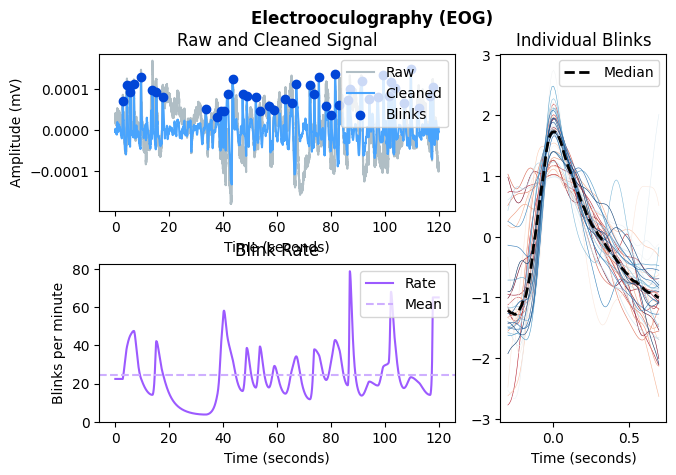

In [9]:
# Import EOG data
samp2_eog_signal = nk.data("eog_100hz")

# Process it
samp2_signals, samp2_info = nk.eog_process(samp2_eog_signal, sampling_rate=100)

# Plot
nk.eog_plot(samp2_signals, samp2_info)

Sample #3 (ECG)

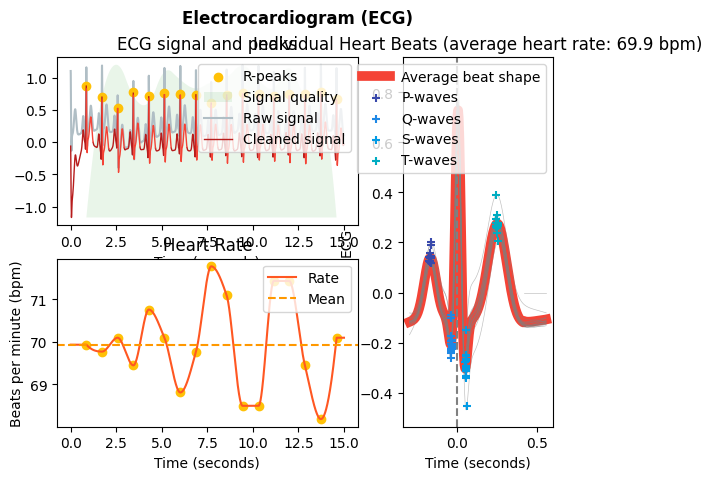

In [10]:
# Generate 15 seconds of ECG signal (recorded at 250 samples/second)
ecg = nk.ecg_simulate(duration=15, sampling_rate=250, heart_rate=70)

# Process it
signals, info = nk.ecg_process(ecg, sampling_rate=250)

# Visualise the processing
nk.ecg_plot(signals, info)

For our project, after the raw data was put into parquet files to be shared, we were able to run the Neurokit2 functions to extract features from the EEG, EOG, and EMG recordings. 

In [11]:
# Loading data into dataframe
df = pd.read_parquet("./data/subj1.parquet")
df.head()

,EEG Fpz-Cz_1,EEG Pz-Oz_1,EOG horizontal_1,EMG Submental_1,Hyp_1
0,-0.000018,0.000007,0.000028,4.002038,0.0
1,-0.000013,0.000002,0.000014,4.003099,0.0
2,0.000005,-0.000005,0.000029,4.004188,0.0
3,-0.000006,-0.000008,0.000014,4.005303,0.0
4,0.000002,-0.000006,0.000020,4.006445,0.0


------------------------------------------------

**Starting with EMG:**

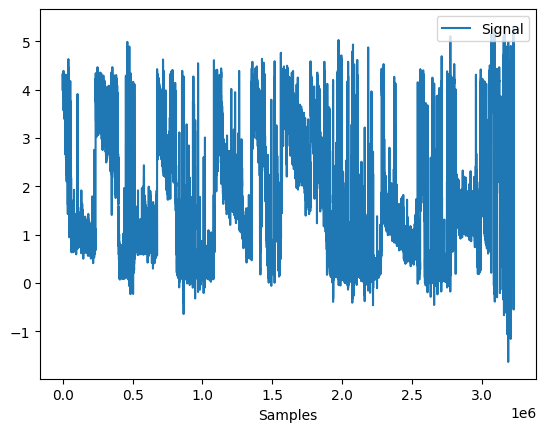

In [12]:
# Specifying EMG signal data, not super clean
emg_signal = df['EMG Submental_1']
nk.signal_plot(emg_signal)

**1.) Cleaning the signal**

In [13]:
# Making simple Bandpass filter to center and clean data emulating neurokit function
def AHM_emg_clean(signal, sampling_rate=100, lowcut=1, highcut=49, order=1):
    nyquist = sampling_rate / 2
    sos = sc.signal.butter(order, [lowcut / nyquist, highcut / nyquist], btype='band', output='sos')
    filtered = sc.signal.sosfilt(sos, signal)
    return filtered

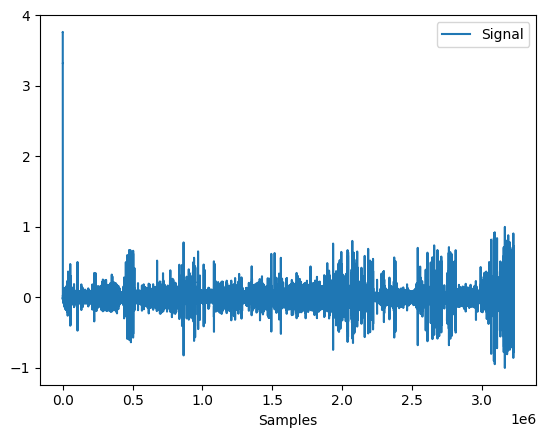

In [14]:
# Applying clean, huge spike at beginning is creating issues
emg_cleaned = AHM_emg_clean(emg_signal)
nk.signal_plot(emg_cleaned)

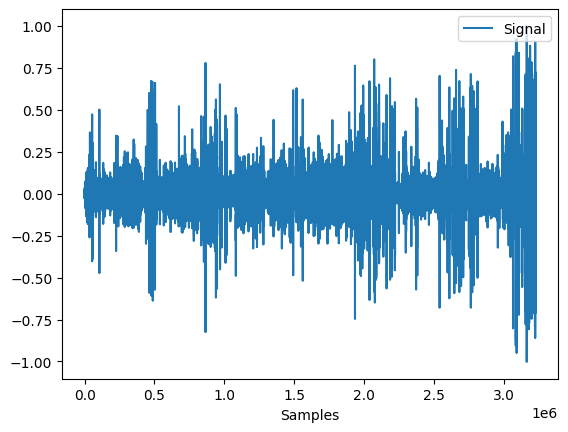

In [15]:
# Not the prettiest solution but setting first 200 values (2 seconds) to zero to eliminate large spike

emg_cleaned_0200 = emg_cleaned.copy()
emg_cleaned_0200[:200] = 0
nk.signal_plot(emg_cleaned_0200)

**2.) Extracting features**

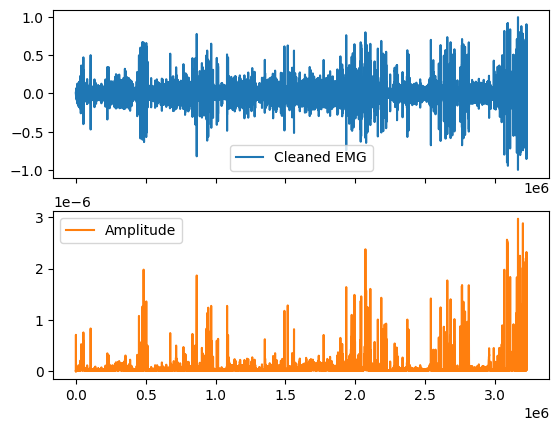

In [16]:
# Running neurokit2 amplitude function, it creates amplitude values from the signal

emg_amplitude = nk.emg_amplitude(emg_cleaned_0200)
fig = pd.DataFrame({"Cleaned EMG": emg_cleaned_0200, "Amplitude": emg_amplitude}).plot(subplots=True)

In [17]:
# Running neurokit2 activity funtion, it uses a gaussian mixture model to identify activation from amplitude data

emg_activity, info = nk.emg_activation(emg_amplitude=emg_amplitude)

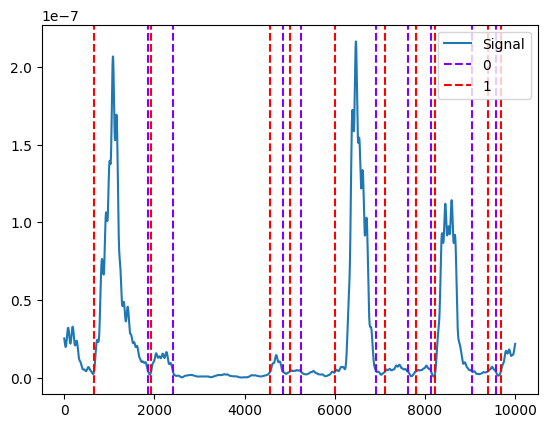

In [18]:
# Sample of what the identification looks like
activity_sample, info_sample = nk.emg_activation(emg_amplitude=emg_amplitude[2000000:2010000])
nk.events_plot([info_sample["EMG_Offsets"], info_sample["EMG_Onsets"]], emg_amplitude[2000000:2010000])

In [19]:
# Adding amplitude column to activity data
emg_activity['EMG_Amplitude'] = emg_amplitude

# Creating 30 sec epochs
event_onsets_emg = np.arange(0, len(emg_signal), 3000)
emg_epochs = nk.epochs_create(emg_activity, events=event_onsets_emg, sampling_rate=100)

c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\epochs\eventrelated_utils.py:37: NeuroKitWarning: emg_eventrelated(): The duration of your epochs seems quite long. You might want to use emg_intervalrelated().
  warn(


,Label,Event_Onset,EMG_Activation,EMG_Amplitude_Mean,EMG_Amplitude_Max,EMG_Amplitude_SD,EMG_Amplitude_Max_Time,EMG_Bursts
1,1,0,1,3.291790e-07,6.998460e-07,2.314875e-07,2.000667,1.0
2,2,3000,1,1.759563e-08,2.230240e-08,2.760867e-09,19.586529,1.0
3,3,6000,0,NaN,NaN,NaN,NaN,NaN
4,4,9000,1,2.086021e-08,2.938142e-08,4.732392e-09,27.129043,2.0
5,5,12000,1,1.601815e-08,2.222536e-08,2.537544e-09,18.936312,3.0


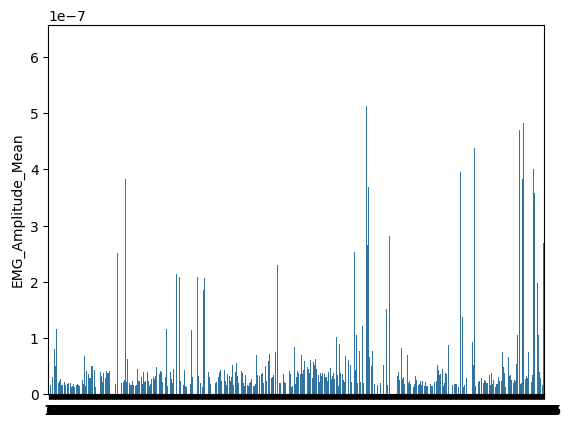

In [20]:
# Running event related function to extract event features

emg_event_data = nk.emg_eventrelated(emg_epochs)

# Sample plot of amplitude mean
sns.barplot(emg_event_data['EMG_Amplitude_Mean'])
emg_event_data.head()

Features are ready for analysis

----------------------
**Next section, EOG:**

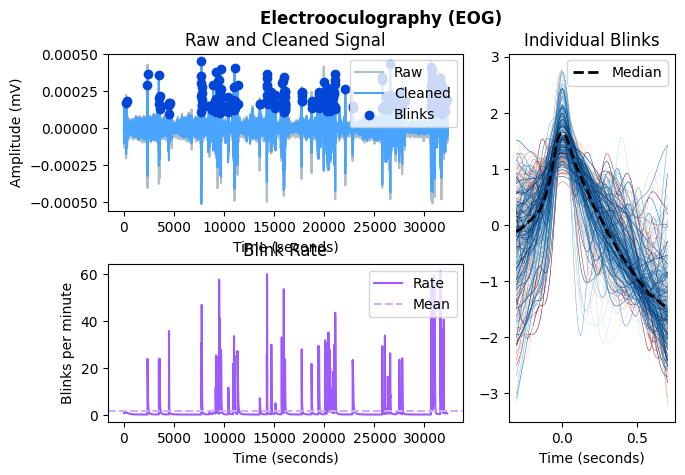

In [21]:
# Separating eog data
eog_df = df[["EOG horizontal_1"]].copy()
eog_signal = eog_df["EOG horizontal_1"]  

# Process signal
eog_signals, info = nk.eog_process(eog_signal, sampling_rate=100)

# Plot
nk.eog_plot(eog_signals, info)

In [ ]:
# Process EOG signal with specified sampling rate
eog_signals, eog_info = nk.eog_process(eog_signal, sampling_rate=100)

# Create a figure with 2 subplots (one column)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot Raw and Cleaned EOG Signal
axes[0].plot(eog_signals.index, eog_signals["EOG_Raw"], label="Raw", color="gray", alpha=0.6)
axes[0].plot(eog_signals.index, eog_signals["EOG_Clean"], label="Cleaned", color="blue", linewidth=1)
axes[0].scatter(eog_signals.index, eog_signals["EOG_Blinks"] * 0.0001, label="Blinks", color="darkblue", alpha=0.7, s=10)
axes[0].set_title("Raw and Cleaned EOG Signal", fontsize=14)
axes[0].set_ylabel("Amplitude (mV)", fontsize=12)
axes[0].set_xlabel("Time (seconds)", fontsize=12)
axes[0].legend()

# Plot Blink Rate Over Time
axes[1].plot(eog_signals.index, eog_signals["EOG_Rate"], color="purple", linewidth=1, alpha=0.8)
axes[1].axhline(eog_signals["EOG_Rate"].mean(), color="purple", linestyle="dashed", label="Mean Rate")
axes[1].set_title("Blinks Per Minute", fontsize=14)
axes[1].set_ylabel("Blinks per Minute", fontsize=12)
axes[1].set_xlabel("Time (seconds)", fontsize=12)
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

C:\Users\Shadow\AppData\Local\Temp\ipykernel_15948\3101319920.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Shadow\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
# Creating 30 sec epochs
event_onsets_eog = np.arange(0, len(eog_signals), 3000)
eog_epochs = nk.epochs_create(eog_signals, events=event_onsets_eog, sampling_rate=100)

eog_epochs_df = nk.epochs_to_df(eog_epochs)

In [ ]:
# Creating interval features dataframe
eog_intervals_df = nk.eog_intervalrelated(eog_epochs)

# Convert Label to numeric type
eog_intervals_df["Label"] = pd.to_numeric(eog_intervals_df["Label"], errors="coerce")

eog_intervals_df.dropna(subset=["Label"], inplace=True)

# Convert Label to int if you want integer epoch labels
eog_intervals_df["Label"] = eog_intervals_df["Label"].astype(int)

In [ ]:
# Convert Label to numeric type
eog_intervals_df["Label"] = pd.to_numeric(eog_intervals_df["Label"], errors="coerce")

eog_intervals_df.dropna(subset=["Label"], inplace=True)

# Convert Label to int if you want integer epoch labels
eog_intervals_df["Label"] = eog_intervals_df["Label"].astype(int)

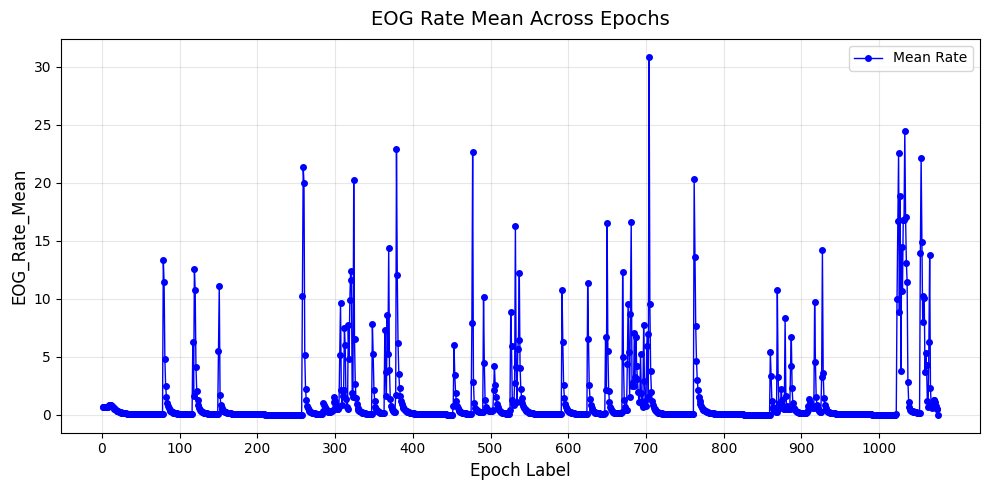

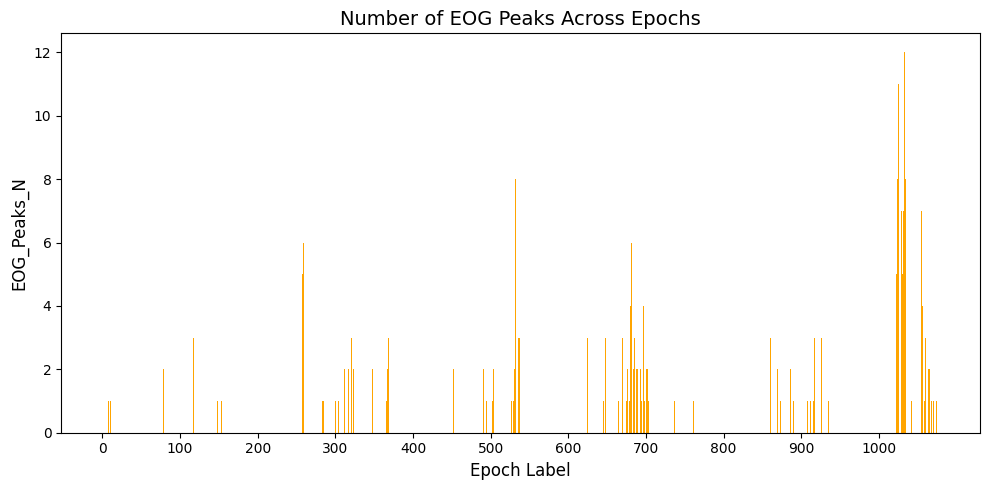

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot EOG_Rate_Mean vs. Label
ax.plot(eog_intervals_df["Label"], eog_intervals_df["EOG_Rate_Mean"],
        marker="o", markersize=4, linestyle="-", linewidth=1,
        color="blue", label="Mean Rate")

ax.set_title("EOG Rate Mean Across Epochs", fontsize=14, pad=10)
ax.set_xlabel("Epoch Label", fontsize=12)
ax.set_ylabel("EOG_Rate_Mean", fontsize=12)

# Group x-axis ticks in increments of 100
max_label = eog_intervals_df["Label"].max()  # Highest epoch label
ax.set_xticks(np.arange(0, max_label + 1, 100))

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(eog_intervals_df["Label"], eog_intervals_df["EOG_Peaks_N"], color="orange")

ax.set_title("Number of EOG Peaks Across Epochs", fontsize=14)
ax.set_xlabel("Epoch Label", fontsize=12)
ax.set_ylabel("EOG_Peaks_N", fontsize=12)

#Group x-axis ticks in increments of 100
max_label = eog_intervals_df["Label"].max()
ax.set_xticks(np.arange(0, max_label + 1, 100))
plt.tight_layout()
plt.show()

c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\epochs\eventrelated_utils.py:37: NeuroKitWarning: eog_eventrelated(): The duration of your epochs seems quite long. You might want to use eog_intervalrelated().
  warn(


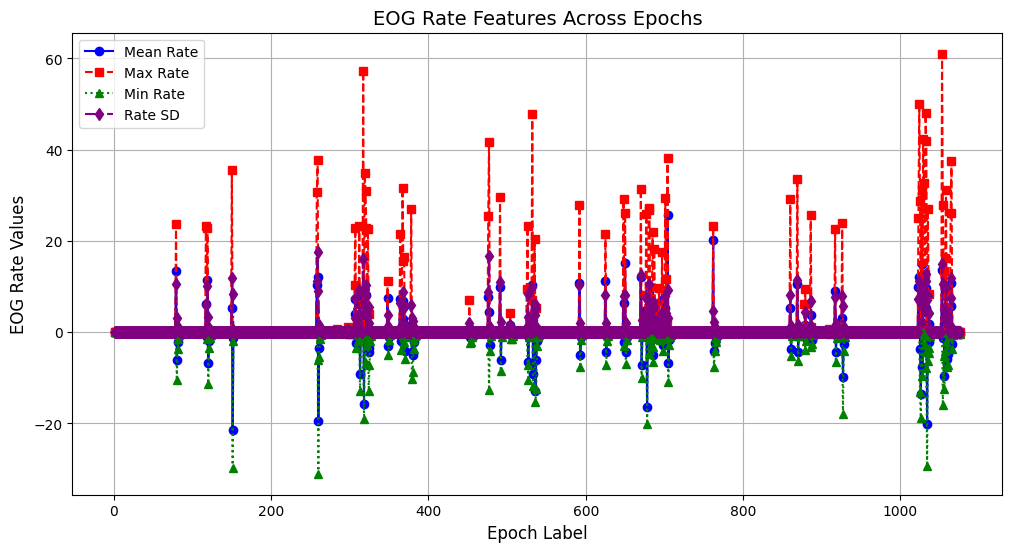

In [ ]:
eog_events_df = nk.eog_eventrelated(eog_epochs)

# Convert Label to numeric type
eog_events_df["Label"] = pd.to_numeric(eog_events_df["Label"], errors="coerce")

eog_events_df.dropna(subset=["Label"], inplace=True)

# Convert Label to int if you want integer epoch labels
eog_events_df["Label"] = eog_events_df["Label"].astype(int)

plt.figure(figsize=(12, 6))

# Plot EOG_Rate_Mean
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_Mean"], label="Mean Rate",
         marker="o", linestyle="-", color="blue")

# Plot EOG_Rate_Max
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_Max"], label="Max Rate",
         marker="s", linestyle="--", color="red")

# Plot EOG_Rate_Min
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_Min"], label="Min Rate",
         marker="^", linestyle=":", color="green")

# Plot EOG_Rate_SD
plt.plot(eog_events_df["Label"], eog_events_df["EOG_Rate_SD"], label="Rate SD",
         marker="d", linestyle="-.", color="purple")

plt.xlabel("Epoch Label", fontsize=12)
plt.ylabel("EOG Rate Values", fontsize=12)
plt.title("EOG Rate Features Across Epochs", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


-----------------
**Next section: EEG**

In [ ]:
# Extract EEG signals (ensure they exist in your dataset)
eeg_data = df[["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]].to_numpy().T  # Convert to NumPy array (transpose for MNE format)

# Create MNE Info object
sfreq = 100  # Set your sampling rate (change if different)
ch_names = ["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]
ch_types = ["eeg", "eeg"]

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create MNE RawArray object
raw_eeg = mne.io.RawArray(eeg_data, info)


Creating RawArray with float64 data, n_channels=2, n_times=3227999
    Range : 0 ... 3227998 =      0.000 ... 32279.980 secs
Ready.


c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\neurokit2\eeg\eeg_badchannels.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


Bad Channels Detected: []


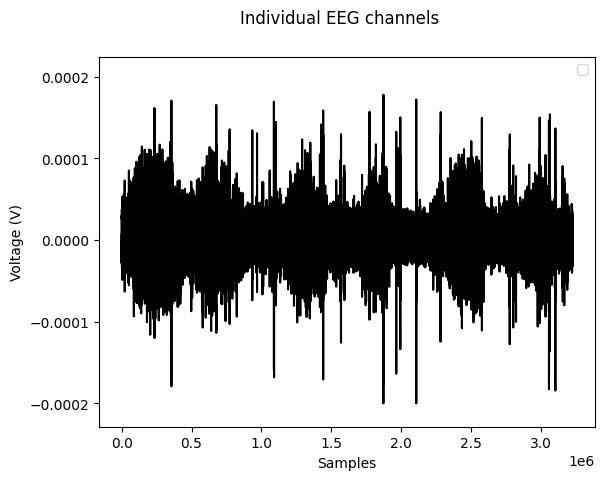

In [ ]:
# Detect bad channels
bads, info = nk.eeg_badchannels(raw_eeg, distance_threshold=0.95, show=True)

# Print the detected bad channels
print("Bad Channels Detected:", bads)

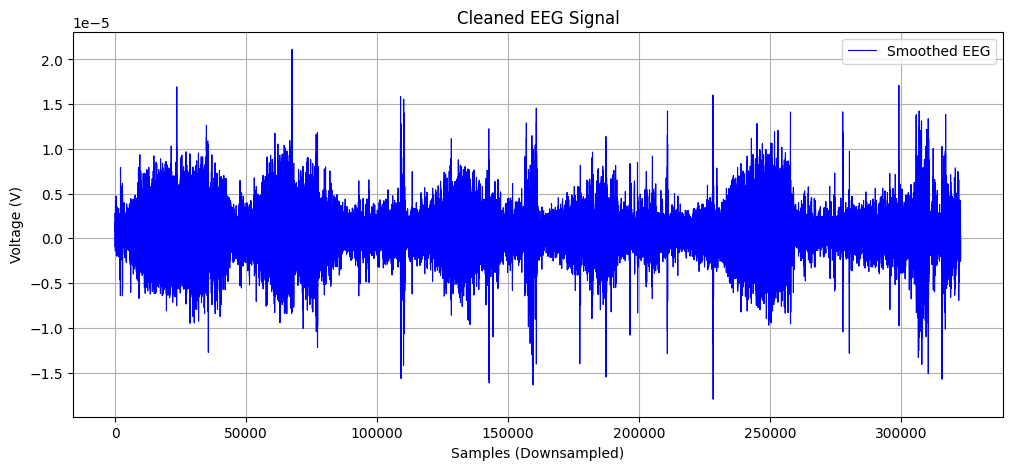

In [ ]:
# Extract EEG signal (assuming you have a raw EEG object)
eeg_signal = raw_eeg.get_data()[0]  # Extract first channel

# Downsample the signal (reduce number of points for a cleaner plot)
downsample_factor = 10  # Adjust this for smoother plots
eeg_downsampled = eeg_signal[::downsample_factor]

# Apply a simple moving average filter to smooth the signal
window_size = 50  # Adjust for smoothness
eeg_smoothed = np.convolve(eeg_downsampled, np.ones(window_size)/window_size, mode='valid')

# Plot the cleaned EEG signal
plt.figure(figsize=(12, 5))
plt.plot(eeg_smoothed, color="blue", linewidth=0.8, label="Smoothed EEG")
plt.xlabel("Samples (Downsampled)")
plt.ylabel("Voltage (V)")
plt.title("Cleaned EEG Signal")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Compute EEG power using Welch's method
eeg_power = nk.eeg_power(raw_eeg, sampling_rate=100, method="welch")

# Extract specific power bands
delta_power = np.mean(eeg_power["Delta"])
theta_power = np.mean(eeg_power["Theta"])
alpha_power = np.mean(eeg_power["Alpha"])
beta_power = np.mean(eeg_power["Beta"])

# Print power values
print(f"Delta Power: {delta_power}")
print(f"Theta Power: {theta_power}")
print(f"Alpha Power: {alpha_power}")
print(f"Beta Power: {beta_power}")

Delta Power: 0.012788401466455728
Theta Power: 0.002333829364701924
Alpha Power: 0.0008504858920539121
Beta Power: 0.0004761277152017659


In [ ]:
# Define epoch length (30s)
epoch_length = 30  # seconds
sampling_rate = 100  # Adjust based on your data
samples_per_epoch = epoch_length * sampling_rate

# Convert MNE Raw object to DataFrame
eeg_df = pd.DataFrame(raw_eeg.get_data().T, columns=raw_eeg.ch_names)  # Transpose to match timepoints

# Convert EEG DataFrame columns to numeric (force conversion)
eeg_df = eeg_df.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values (if needed)
eeg_df.dropna(inplace=True)

# OR: Fill NaN values with zero (if drop is not possible)
eeg_df.fillna(0, inplace=True)


# Convert EEG data from volts (V) to microvolts (µV) for proper scaling
eeg_df *= 1e6  # Now in microvolts

# Generate event onsets at fixed intervals (every 30s)
event_onsets = np.arange(0, len(eeg_df), samples_per_epoch)

# Create epochs
epochs = nk.epochs_create(eeg_df, events=event_onsets, sampling_rate=sampling_rate)


# Ensure all epochs contain numerical values
for epoch in epochs.keys():
    epochs[epoch] = epochs[epoch].apply(pd.to_numeric, errors='coerce')
    
# Convert epochs to DataFrame for inspection
eeg_epochs_df = nk.epochs_to_df(epochs)

print(eeg_epochs_df.head())

   EEG Fpz-Cz_1  EEG Pz-Oz_1  Index  Label      Time
0    -18.490410     6.842756      0      1  0.000000
1    -12.687343     1.935454      1      1  0.010003
2      4.830030    -4.646464      2      1  0.020007
3     -6.171618    -7.787137      3      1  0.030010
4      2.488441    -5.824216      4      1  0.040013


In [ ]:
# Define your EEG channel names (adjust if needed)
eeg_channels = ["EEG Fpz-Cz_1", "EEG Pz-Oz_1"]

# Create a list to store power values for each epoch.
epoch_power_features = []

# Iterate over epochs in numerical order (convert keys to int for proper sorting)
for key in sorted(epochs.keys(), key=int):
    epoch_data = epochs[key]
    
    # Select only the EEG channels (this will drop extra columns like "Index", "Label", "Time", etc.)
    try:
        epoch_eeg = epoch_data[eeg_channels]
    except KeyError:
        print(f"Epoch {key}: one or more EEG channel(s) missing.")
        continue

    # Convert the EEG data to numeric (force conversion in case some values are strings)
    epoch_eeg = epoch_eeg.apply(pd.to_numeric, errors='coerce')
    # Drop any rows with NaN values
    epoch_eeg = epoch_eeg.dropna()
    
    # If after cleaning the epoch is empty, skip it
    if epoch_eeg.empty:
        print(f"Epoch {key} is empty after cleaning; skipping.")
        continue

    # Now compute EEG power using Welch's method
    try:
        power_bands = nk.eeg_power(epoch_eeg, sampling_rate=sampling_rate, method="welch")
    except Exception as e:
        print(f"Epoch {key}: error computing EEG power: {e}")
        continue

    # Check if the expected key "Hz_1_4" (Delta) is in the result
    if "Hz_1_4" not in power_bands:
        print(f"Epoch {key}: power_bands keys are {list(power_bands.keys())}, skipping this epoch.")
        continue

# Map the returned keys to standard EEG bands
    epoch_features = {
        "Epoch": key,
        "Delta": np.mean(power_bands["Hz_1_4"]),
        "Theta": np.mean(power_bands["Hz_4_8"]),
        "Alpha": np.mean(power_bands["Hz_8_13"]),
        "Beta": np.mean(power_bands["Hz_13_30"]),
        "Gamma": np.mean(power_bands.get("Hz_30_80", [np.nan])),  # Optional Gamma band
    }
    epoch_power_features.append(epoch_features)

# Convert the list of epoch features into a DataFrame
eeg_epoch_power_df = pd.DataFrame(epoch_power_features)

# Print the first few rows of the resulting DataFrame
print(eeg_epoch_power_df.head())

  Epoch     Delta     Theta     Alpha      Beta     Gamma
0     1  0.178851  0.556169  0.316026  0.048283  0.023247
1     2  0.143499  0.311799  0.165421  0.046112  0.042361
2     3  0.085178  0.397235  0.166785  0.035458  0.012592
3     4  0.113562  0.429030  0.187841  0.036416  0.012837
4     5  0.137373  0.569296  0.286778  0.059488  0.018182


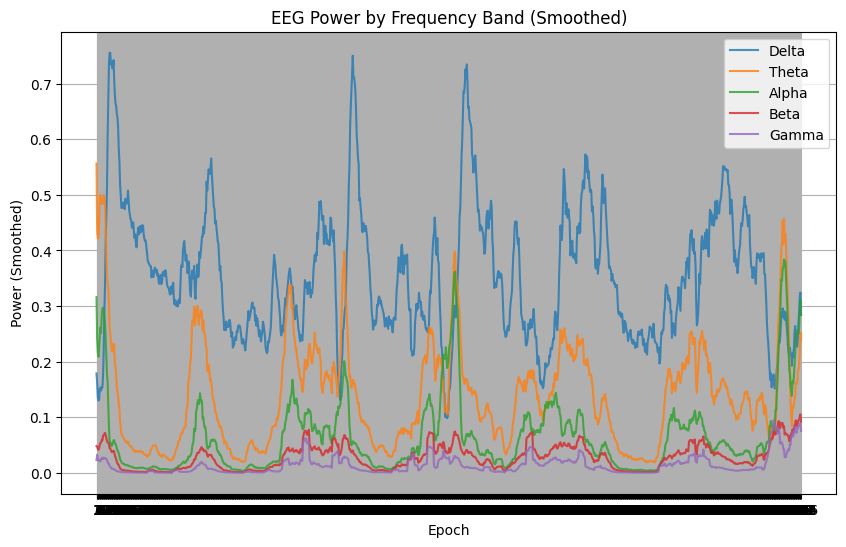

In [ ]:
# Make a copy of the DataFrame
df_rolling = eeg_epoch_power_df.copy()

# Apply a rolling average (window size can be adjusted)
window_size = 10
df_rolling[["Delta","Theta","Alpha","Beta","Gamma"]] = (
    df_rolling[["Delta","Theta","Alpha","Beta","Gamma"]]
    .rolling(window_size, min_periods=1)
    .mean()
)

# Plot the smoothed data on a single plot
plt.figure(figsize=(10, 6))
plt.plot(df_rolling["Epoch"], df_rolling["Delta"], label="Delta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Theta"], label="Theta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Alpha"], label="Alpha", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Beta"], label="Beta", alpha=0.8)
plt.plot(df_rolling["Epoch"], df_rolling["Gamma"], label="Gamma", alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Power (Smoothed)")
plt.title("EEG Power by Frequency Band (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

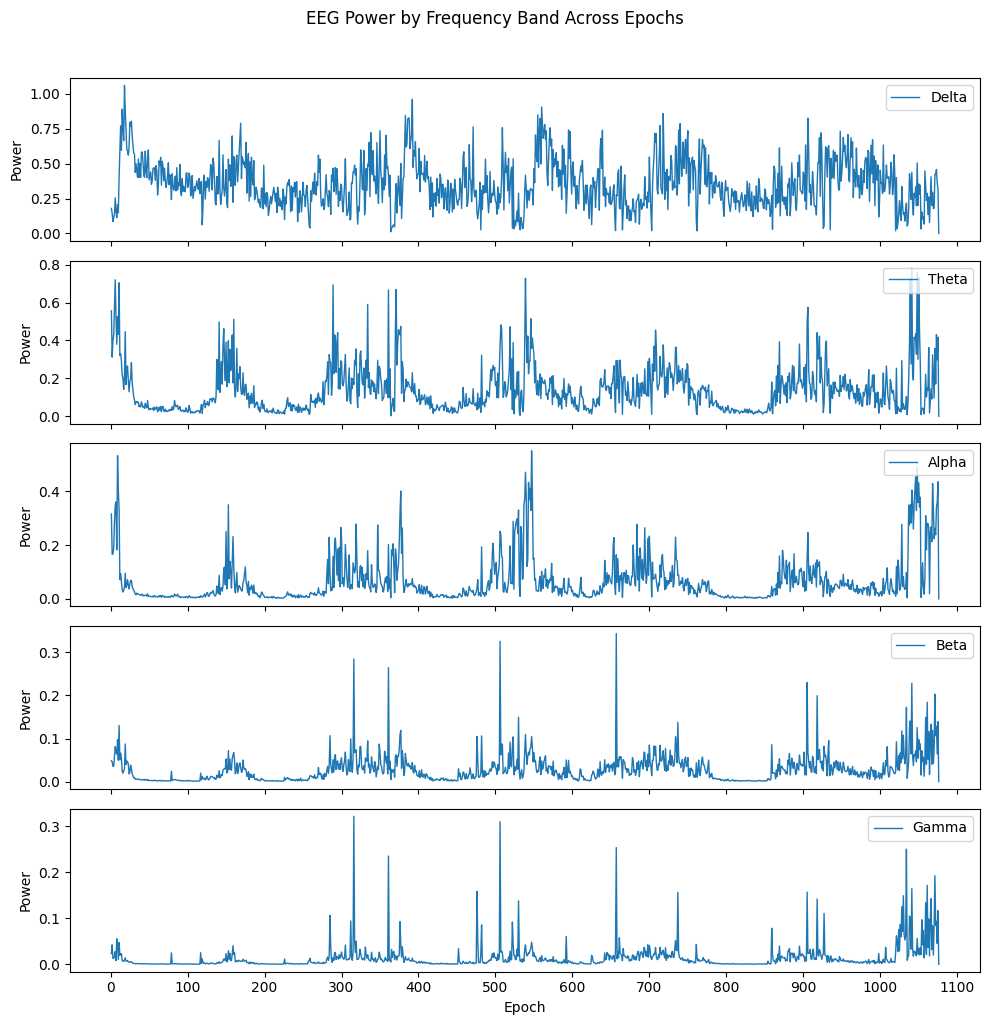

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Convert the Epoch column to integer if it's not already
eeg_epoch_power_df["Epoch"] = eeg_epoch_power_df["Epoch"].astype(int)

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(10, 10), sharex=True)

for i, band in enumerate(bands):
    axes[i].plot(eeg_epoch_power_df["Epoch"], eeg_epoch_power_df[band], label=band, marker="", linewidth=1.0)
    axes[i].set_ylabel("Power")
    axes[i].legend(loc="upper right")
    # Set major ticks at every 100 epochs
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(100))

axes[-1].set_xlabel("Epoch")
plt.suptitle("EEG Power by Frequency Band Across Epochs", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load original dataframe with hypnogram (already at 100Hz, total length: 3227999)
df_hyp = pd.read_parquet("data/subj1.parquet")

# Hypnogram column
hypnogram = df.filter(like='Hyp').iloc[:, 0].reset_index(drop=True)
import numpy as np

samples_per_epoch = 3000  # 30 sec * 100 Hz = 3000 samples

# Define a helper function clearly
def upsample_epoch_df(df, samples_per_epoch):
    repeated_array = np.repeat(df.values, repeats=samples_per_epoch, axis=0)
    upsampled_df = pd.DataFrame(repeated_array, columns=df.columns)
    return upsampled_df

# Upsample each feature explicitly:
upsampled_eeg = upsample_epoch_df(eeg_epoch_power_df, samples_per_epoch)
upsampled_eog = upsample_epoch_df(eog_events_df, samples_per_epoch)
upsampled_emg = upsample_epoch_df(emg_event_data, samples_per_epoch)

# Confirm upsampling explicitly
print(f"EEG shape after upsampling: {upsampled_eeg.shape}")


EEG shape after upsampling: (3228000, 6)


In [ ]:
# Ensure matching number of rows explicitly
min_length = min(len(hypnogram), len(upsampled_eeg))

# Merge features explicitly into one dataframe
final_df = pd.concat([
    upsampled_eeg.iloc[:min_length].reset_index(drop=True),
    upsampled_eog.iloc[:min_length].reset_index(drop=True),
    upsampled_emg.iloc[:min_length].reset_index(drop=True),
    pd.Series(hypnogram[:min_length], name='Sleep_Stage')
], axis=1)
final_df = final_df.loc[:, ~final_df.columns.str.contains('Label')]

final_df.head()

,Epoch,Delta,Theta,Alpha,Beta,Gamma,Event_Onset,EOG_Rate_Baseline,EOG_Rate_Max,EOG_Rate_Min,...,EOG_Rate_Min_Time,EOG_Blinks_Presence,Event_Onset,EMG_Activation,EMG_Amplitude_Mean,EMG_Amplitude_Max,EMG_Amplitude_SD,EMG_Amplitude_Max_Time,EMG_Bursts,Sleep_Stage
0,1.0,0.178851,0.556169,0.316026,0.048283,0.023247,0.0,0.675209,0.0,0.0,...,0.010003,0.0,0,1,0.0,0.000001,0.0,2.000667,1.0,0.0
1,1.0,0.178851,0.556169,0.316026,0.048283,0.023247,0.0,0.675209,0.0,0.0,...,0.010003,0.0,0,1,0.0,0.000001,0.0,2.000667,1.0,0.0
2,1.0,0.178851,0.556169,0.316026,0.048283,0.023247,0.0,0.675209,0.0,0.0,...,0.010003,0.0,0,1,0.0,0.000001,0.0,2.000667,1.0,0.0
3,1.0,0.178851,0.556169,0.316026,0.048283,0.023247,0.0,0.675209,0.0,0.0,...,0.010003,0.0,0,1,0.0,0.000001,0.0,2.000667,1.0,0.0
4,1.0,0.178851,0.556169,0.316026,0.048283,0.023247,0.0,0.675209,0.0,0.0,...,0.010003,0.0,0,1,0.0,0.000001,0.0,2.000667,1.0,0.0


In [ ]:
hyp_data_long = pd.DataFrame(df['Hyp_1'])
hyp_data = hyp_data_long.iloc[::3000]
hyp_data = hyp_data.reset_index().drop('index', axis=1)
final_df['Sleep_Stage'] = hyp_data.values

In [ ]:
final_df.to_csv("data/processed_sub1.csv", index=False)


NameError: name 'final_df' is not defined

In [98]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Clearly identify columns to drop (any redundant label columns + epoch)
cols_to_drop = [col for col in final_df.columns if 'Label' in col] + ['Epoch', 'Sleep_Stage']
X = final_df.drop(columns=cols_to_drop)
y = final_df['Sleep_Stage'].values

# Standardize features explicitly
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Explicitly handle NaNs with mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)

# PCA explicitly performed
pca = PCA(n_components=min(10, X_imputed.shape[1]))
principal_components = pca.fit_transform(X_imputed)

# Explained variance explicitly calculated
explained_variance = pca.explained_variance_ratio_
print("Explained Variance per PCA component:", explained_variance)

# Final PCA dataframe explicitly including Sleep_Stage labels
pca_df = pd.DataFrame(principal_components, 
                      columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
pca_df['Sleep_Stage'] = final_df['Sleep_Stage'].values
pca_df['Epoch'] = final_df['Epoch'].values

print(pca_df)


Explained Variance per PCA component: [0.23316298 0.1504371  0.12072102 0.10190979 0.08680374 0.05866162
 0.04624707 0.04465931 0.04202452 0.03601229]
              PC1       PC2       PC3        PC4       PC5       PC6  \
0        2.842135  1.930502  2.276083   0.298098 -4.603740  0.936979   
1        2.842135  1.930502  2.276083   0.298098 -4.603740  0.936979   
2        2.842135  1.930502  2.276083   0.298098 -4.603740  0.936979   
3        2.842135  1.930502  2.276083   0.298098 -4.603740  0.936979   
4        2.842135  1.930502  2.276083   0.298098 -4.603740  0.936979   
...           ...       ...       ...        ...       ...       ...   
3227994  4.819995  0.127596  1.710318  11.224497 -3.045562  1.120727   
3227995  4.819995  0.127596  1.710318  11.224497 -3.045562  1.120727   
3227996  4.819995  0.127596  1.710318  11.224497 -3.045562  1.120727   
3227997  4.819995  0.127596  1.710318  11.224497 -3.045562  1.120727   
3227998  4.819995  0.127596  1.710318  11.224497 -3.04556

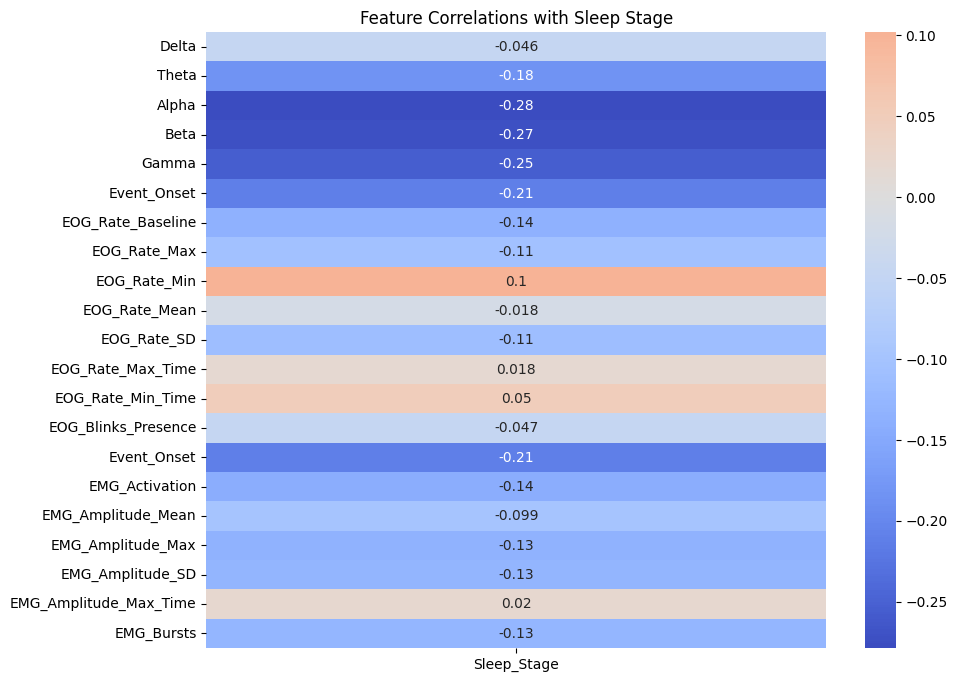

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create features dataframe explicitly from your existing final_df
features_df = final_df.drop(columns=['Epoch', 'Sleep_Stage', 'Label'], errors='ignore')

# Compute correlation matrix explicitly
correlation_matrix = features_df.join(final_df['Sleep_Stage']).corr()

# Explicitly isolate correlation with Sleep_Stage
sleep_corr = correlation_matrix[['Sleep_Stage']].drop('Sleep_Stage')

# Explicit heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(sleep_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations with Sleep Stage')
plt.show()


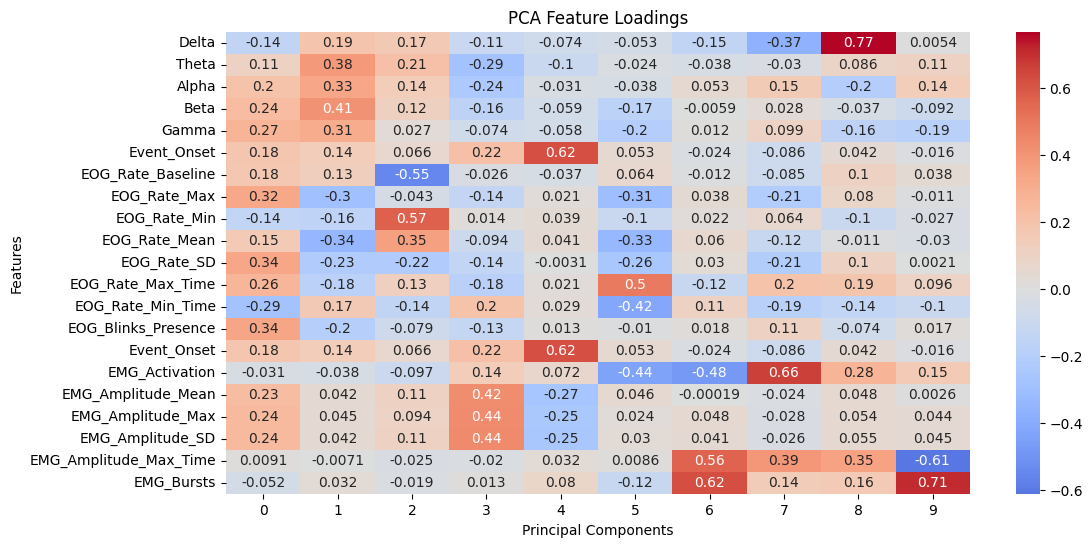

In [77]:
# Clearly extract PCA loadings
loadings = pd.DataFrame(pca.components_, columns=final_df.drop(['Epoch', 'Sleep_Stage'], axis=1).columns)

plt.figure(figsize=(12, 6))
sns.heatmap(loadings.T, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Feature Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()


In [ ]:
final_df['Gamma'].value_counts()

In [85]:
from scipy.stats import f_oneway

feature = 'Theta'  # try different EEG/EMG/EOG features
groups = [final_df[final_df.Sleep_Stage == stage][feature].dropna() for stage in final_df.Sleep_Stage.unique()]
F, p = f_oneway(*groups)

print(f"ANOVA for {feature}: F-statistic={F}, p-value={p}")


ANOVA for Theta: F-statistic=259168.91375387195, p-value=0.0


In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare explicitly:
X = final_df.drop(['Epoch', 'Sleep_Stage', 'Label'], axis=1, errors='ignore')
y = final_df['Sleep_Stage']

# Mean imputation explicitly:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Explicit train/test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest explicitly:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate explicitly:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     78372
         1.0       1.00      1.00      1.00     35662
         2.0       1.00      1.00      1.00    224446
         3.0       1.00      1.00      1.00     56146
         4.0       1.00      1.00      1.00    121745
         5.0       1.00      1.00      1.00    128612
         6.0       1.00      1.00      1.00       617

    accuracy                           1.00    645600
   macro avg       1.00      1.00      1.00    645600
weighted avg       1.00      1.00      1.00    645600



In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

X = final_df.drop(['Epoch', 'Sleep_Stage', 'Label'], axis=1, errors='ignore')
y = final_df['Sleep_Stage']

# Explicit imputation and split:
X_imputed = SimpleImputer(strategy='mean').fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, random_state=42, test_size=0.2)

# Train explicitly:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Feature importance explicitly:
importance_df = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importance_df)


Gamma                     0.169605
Beta                      0.112781
Alpha                     0.111092
Delta                     0.090211
Theta                     0.078627
Event_Onset               0.076858
Event_Onset               0.071910
EOG_Rate_Baseline         0.044823
EOG_Rate_Max              0.038336
EOG_Rate_SD               0.034520
EOG_Rate_Mean             0.031389
EOG_Rate_Min              0.024905
EMG_Amplitude_Max_Time    0.022597
EMG_Amplitude_Max         0.020507
EMG_Amplitude_SD          0.020505
EMG_Amplitude_Mean        0.020450
EMG_Bursts                0.010303
EOG_Blinks_Presence       0.008495
EOG_Rate_Max_Time         0.005330
EOG_Rate_Min_Time         0.003972
EMG_Activation            0.002783
dtype: float64


C:\Users\Shadow\AppData\Local\Temp\ipykernel_8372\2258202896.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corr_matrix.index, x=corr_matrix.values, palette='coolwarm')


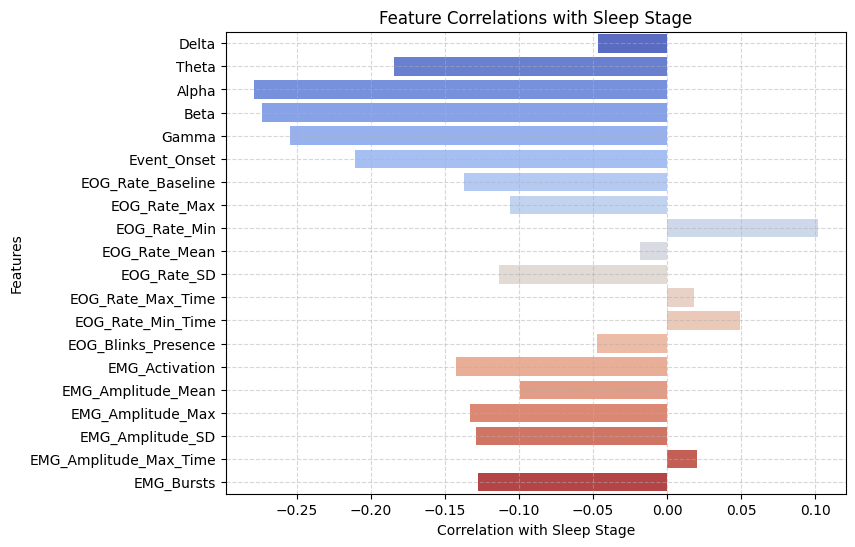

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop unnecessary columns explicitly:
features_df = final_df.drop(columns=['Epoch', 'Sleep_Stage', 'Label'], errors='ignore')

# Compute correlation matrix explicitly:
corr_matrix = features_df.corrwith(final_df['Sleep_Stage'])

# Explicitly visualize:
plt.figure(figsize=(8, 6))
sns.barplot(y=corr_matrix.index, x=corr_matrix.values, palette='coolwarm')
plt.xlabel("Correlation with Sleep Stage")
plt.ylabel("Features")
plt.title("Feature Correlations with Sleep Stage")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

C:\Users\Shadow\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


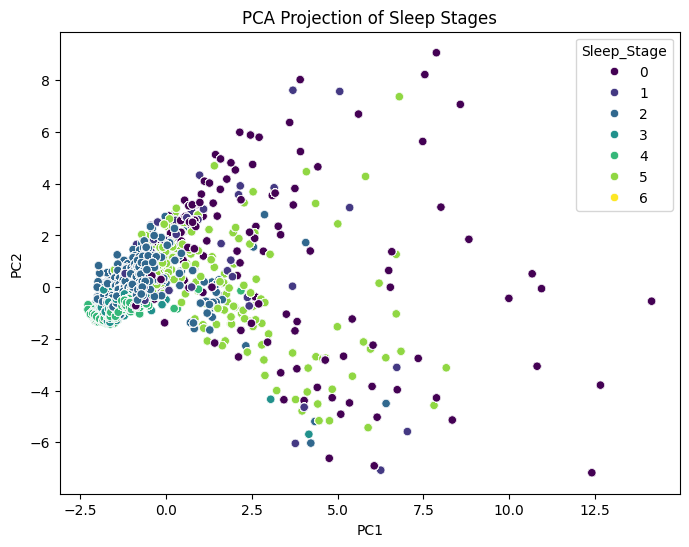

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explicitly drop non-feature columns
X_epoch = final_df.drop(columns=['Epoch', 'Sleep_Stage', 'Label'], errors='ignore')

# Handle NaNs explicitly by imputing missing values:
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with mean
X_imputed = imputer.fit_transform(X_epoch)

# Standardize explicitly
X_scaled_epoch = StandardScaler().fit_transform(X_imputed)

# Run PCA explicitly
pca_epoch = PCA(n_components=2).fit_transform(X_scaled_epoch)

# Create explicit dataframe for visualization:
pca_plot_df = pd.DataFrame(pca_epoch, columns=['PC1', 'PC2'])
pca_plot_df['Sleep_Stage'] = final_df['Sleep_Stage'].values

# Explicit fix: Pass `data=pca_plot_df`
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_plot_df, x="PC1", y="PC2", hue="Sleep_Stage", palette="viridis")
plt.title("PCA Projection of Sleep Stages")
plt.show()


C:\Users\Shadow\AppData\Local\Temp\ipykernel_8372\2329856262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep_Stage', y=feature, data=final_df, palette='viridis')


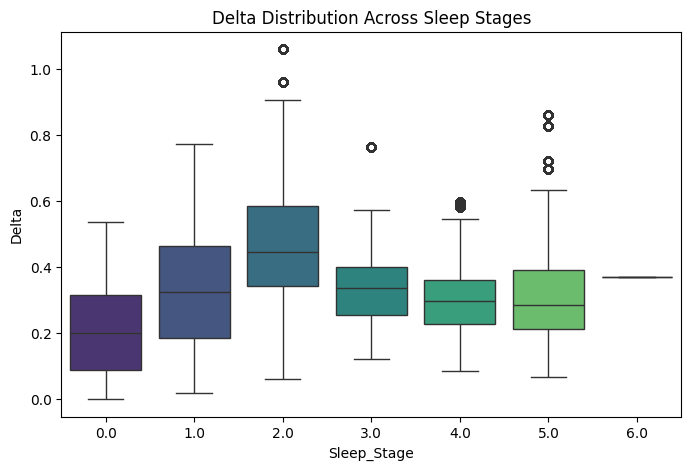

C:\Users\Shadow\AppData\Local\Temp\ipykernel_8372\2329856262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep_Stage', y=feature, data=final_df, palette='viridis')


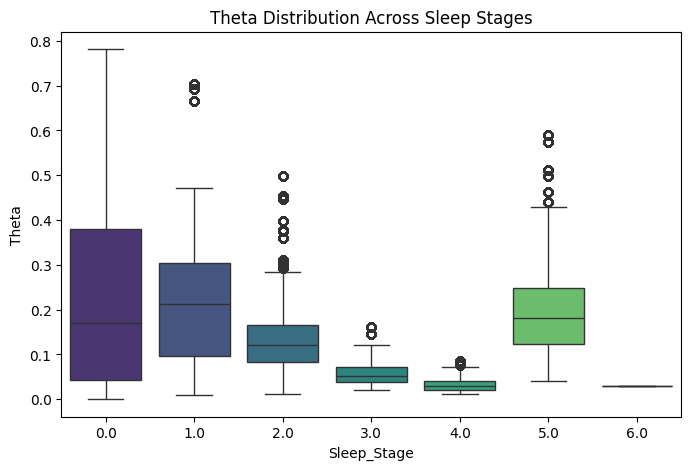

C:\Users\Shadow\AppData\Local\Temp\ipykernel_8372\2329856262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep_Stage', y=feature, data=final_df, palette='viridis')


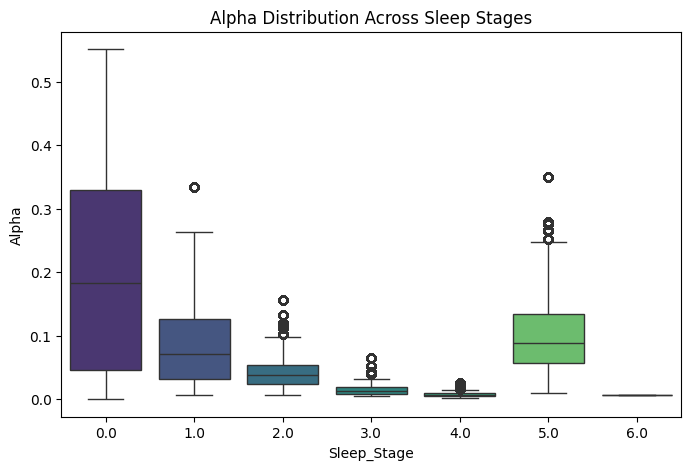

C:\Users\Shadow\AppData\Local\Temp\ipykernel_8372\2329856262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep_Stage', y=feature, data=final_df, palette='viridis')


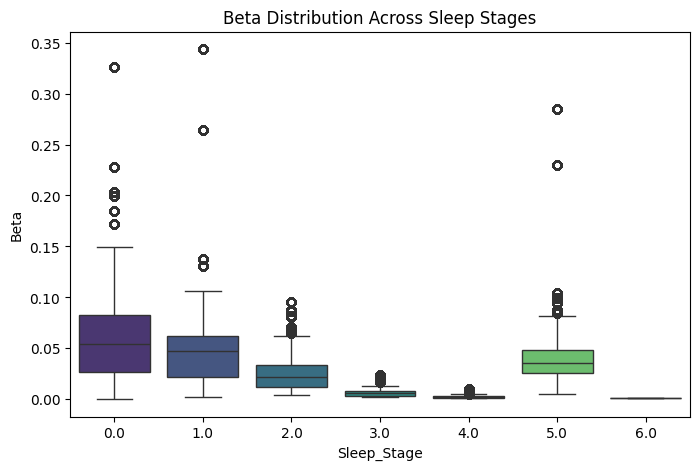

C:\Users\Shadow\AppData\Local\Temp\ipykernel_8372\2329856262.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep_Stage', y=feature, data=final_df, palette='viridis')


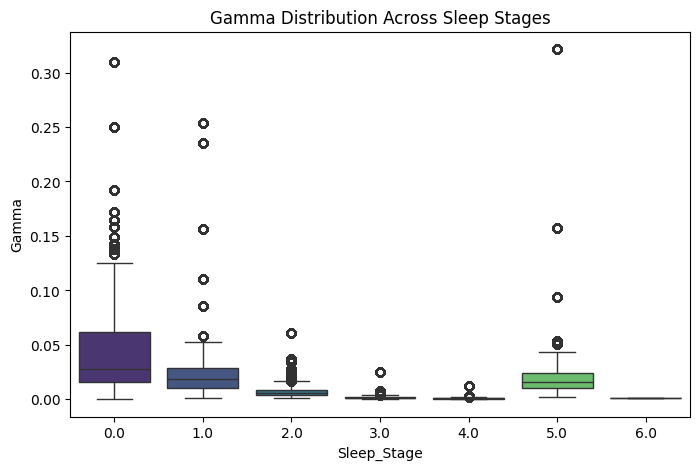

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Explicitly visualize feature distribution for each sleep stage
features_to_plot = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']  # Modify for your dataset

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Sleep_Stage', y=feature, data=final_df, palette='viridis')
    plt.title(f"{feature} Distribution Across Sleep Stages")
    plt.show()



Feature Importance for Sleep Stage 0.0:
Alpha          0.167753
Event_Onset    0.167636
Event_Onset    0.150069
Delta          0.121689
Gamma          0.072137
dtype: float64


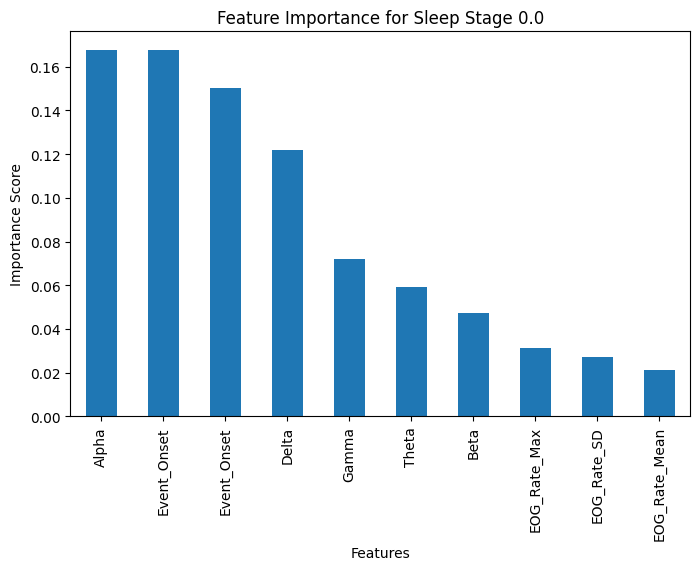


Feature Importance for Sleep Stage 1.0:
Theta          0.077703
Event_Onset    0.077120
Gamma          0.072711
Event_Onset    0.068876
Alpha          0.067775
dtype: float64


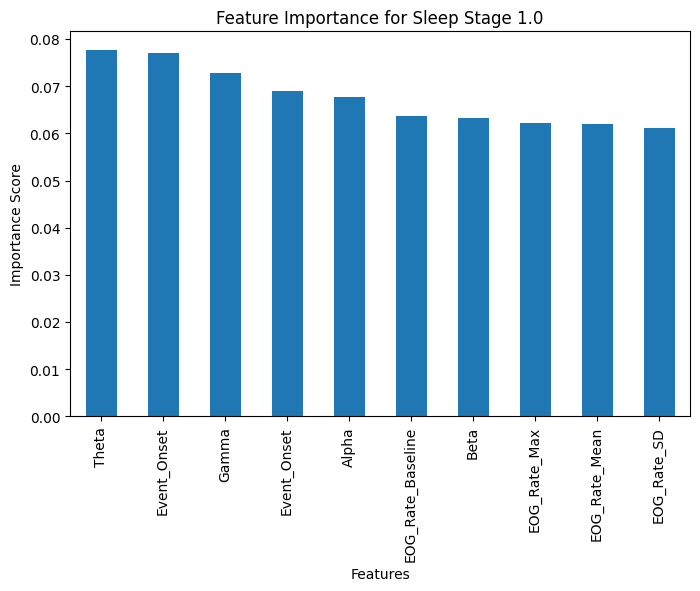


Feature Importance for Sleep Stage 2.0:
Gamma    0.175856
Delta    0.136602
Alpha    0.121184
Beta     0.103633
Theta    0.072474
dtype: float64


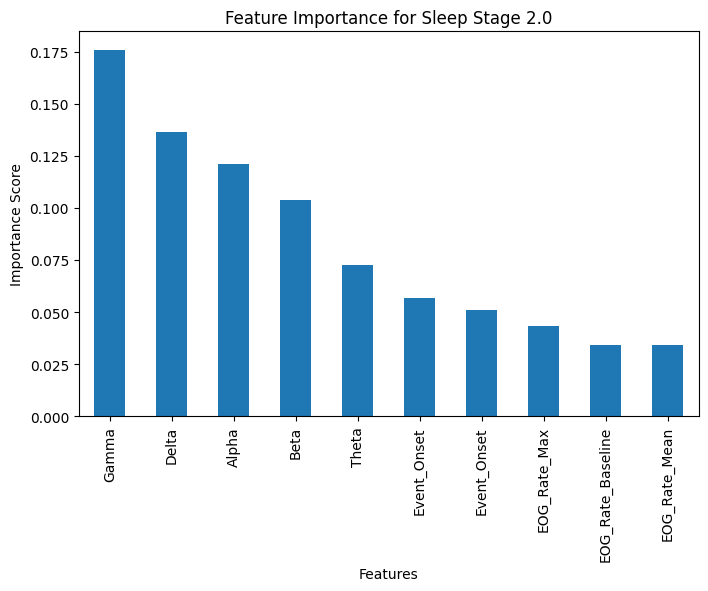


Feature Importance for Sleep Stage 3.0:
Beta                 0.109712
Event_Onset          0.104210
Event_Onset          0.102891
Gamma                0.102510
EOG_Rate_Baseline    0.084964
dtype: float64


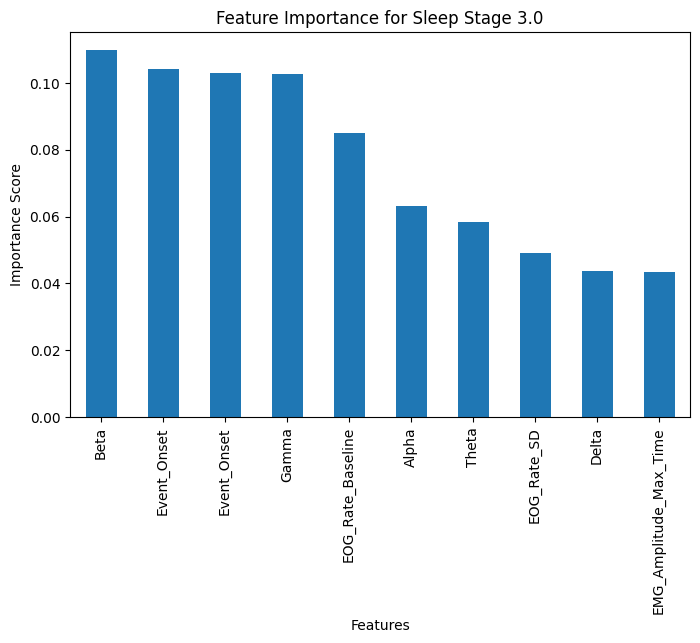


Feature Importance for Sleep Stage 4.0:
Gamma          0.244182
Beta           0.221037
Alpha          0.109165
Theta          0.095645
Event_Onset    0.045263
dtype: float64


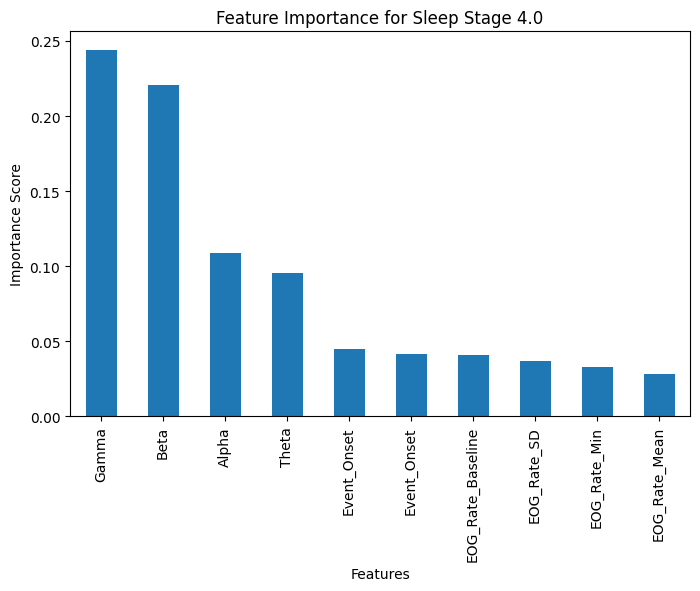


Feature Importance for Sleep Stage 6.0:
Gamma           0.161771
Beta            0.140123
EOG_Rate_Max    0.115751
EOG_Rate_SD     0.110888
Event_Onset     0.098254
dtype: float64


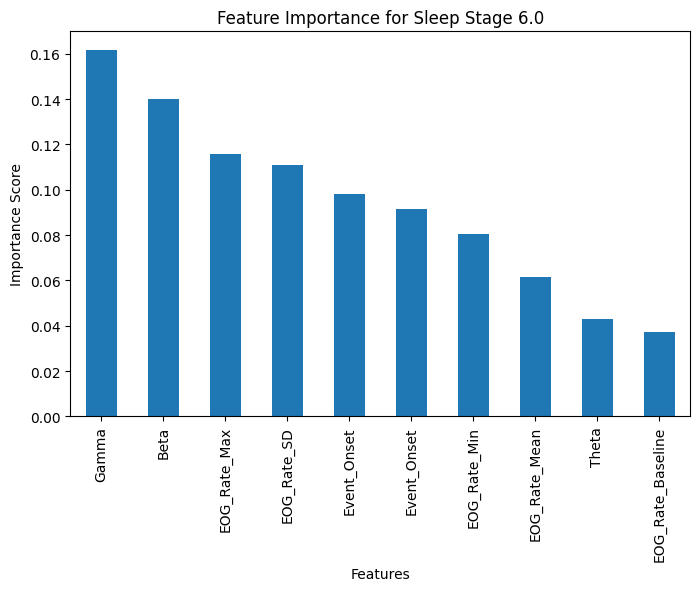


Feature Importance for Sleep Stage 5.0:
Gamma          0.117857
Event_Onset    0.107375
Event_Onset    0.107153
Alpha          0.107030
Delta          0.101018
dtype: float64


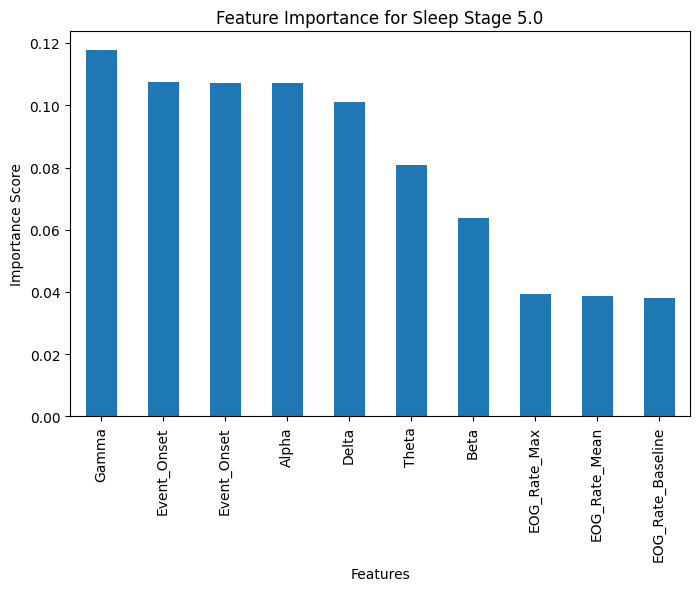

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Prepare dataset explicitly
X = final_df.drop(['Epoch', 'Sleep_Stage', 'Label'], axis=1, errors='ignore')

# Iterate through sleep stages explicitly:
for stage in final_df['Sleep_Stage'].unique():
    print(f"\nFeature Importance for Sleep Stage {stage}:")

    # Create binary labels (1 if current sleep stage, 0 otherwise)
    y_binary = (final_df['Sleep_Stage'] == stage).astype(int)

    # Handle NaNs explicitly:
    X_imputed = SimpleImputer(strategy='mean').fit_transform(X)

    # Split explicitly:
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_binary, test_size=0.2, random_state=42)

    # Train classifier explicitly:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Feature importance explicitly:
    importance_df = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Print top 5 most important features for this stage explicitly:
    print(importance_df.head(5))

    # Plot explicitly:
    importance_df.head(10).plot(kind='bar', figsize=(8, 5))
    plt.title(f"Feature Importance for Sleep Stage {stage}")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.show()


c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Shadow\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


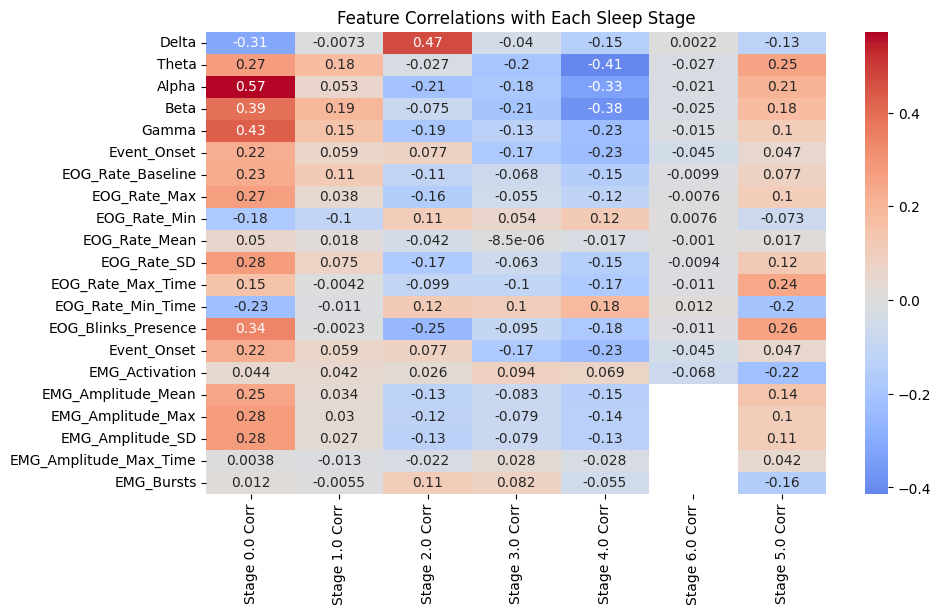

In [ ]:
stage_corr_df = pd.DataFrame(index=X.columns)

# Compute correlation for each sleep stage explicitly
for stage in final_df['Sleep_Stage'].unique():
    y_binary = (final_df['Sleep_Stage'] == stage).astype(int)
    stage_corr_df[f'Stage {stage} Corr'] = X.corrwith(y_binary)

# Explicitly visualize:
plt.figure(figsize=(10, 6))
sns.heatmap(stage_corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlations with Each Sleep Stage")
plt.show()


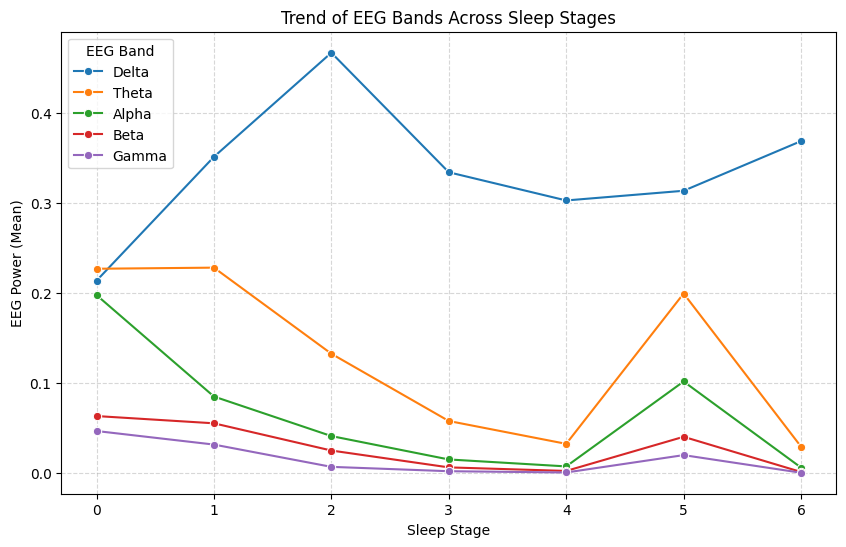

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select EEG frequency bands explicitly:
features_to_plot = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']  # Modify if needed

# Compute the mean EEG power for each sleep stage explicitly:
mean_values = final_df.groupby("Sleep_Stage")[features_to_plot].mean()

# Explicitly plot trendlines:
plt.figure(figsize=(10, 6))
for feature in features_to_plot:
    sns.lineplot(x=mean_values.index, y=mean_values[feature], label=feature, marker="o")

plt.xlabel("Sleep Stage")
plt.ylabel("EEG Power (Mean)")
plt.title("Trend of EEG Bands Across Sleep Stages")
plt.legend(title="EEG Band")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

# ✅ Load and preprocess data
features = final_df.drop(columns=['Sleep_Stage'])  # Remove labels for clustering
labels = final_df['Sleep_Stage']

# ✅ Handle Missing Values (Impute NaNs)
imputer = SimpleImputer(strategy="mean")  # Replace NaNs with column mean
X_imputed = imputer.fit_transform(features)

# ✅ Normalize features for PCA, t-SNE, and clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ✅ 1️⃣ Dimensionality Reduction (PCA & t-SNE)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# ✅ 2️⃣ Clustering (K-Means & Hierarchical)
# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# ✅ 3️⃣ Sleep Stage Transition Matrix
# Compute transition probabilities
transitions = pd.crosstab(labels[:-1], labels[1:])
transitions_normalized = transitions.div(transitions.sum(axis=1), axis=0)

# ✅ 4️⃣ Multimodal vs. Unimodal Analysis
# PCA for EEG-only vs. EEG+EOG+EMG
eeg_features = final_df.filter(like='EEG')
multimodal_features = final_df.drop(columns=['Sleep_Stage'])

X_eeg_scaled = scaler.fit_transform(imputer.fit_transform(eeg_features))
X_multimodal_scaled = scaler.fit_transform(imputer.fit_transform(multimodal_features))

pca_eeg = PCA(n_components=2).fit_transform(X_eeg_scaled)
pca_multimodal = PCA(n_components=2).fit_transform(X_multimodal_scaled)

In [ ]:

# ✅ Visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# PCA Scatterplot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", ax=axes[0, 0])
axes[0, 0].set_title("PCA: Sleep Stage Separation")

# t-SNE Scatterplot
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette="tab10", ax=axes[0, 1])
axes[0, 1].set_title("t-SNE: Sleep Stage Clustering")

# K-Means Clustering
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="tab10", ax=axes[1, 0])
axes[1, 0].set_title("K-Means Clustering (PCA)")

# Hierarchical Clustering
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hierarchical_labels, palette="tab10", ax=axes[1, 1])
axes[1, 1].set_title("Hierarchical Clustering (PCA)")

# Sleep Stage Transition Matrix (Heatmap)
sns.heatmap(transitions_normalized, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[2, 0])
axes[2, 0].set_title("Sleep Stage Transition Matrix")

# Compare EEG-only vs. Multimodal Features (PCA)
sns.scatterplot(x=pca_eeg[:, 0], y=pca_eeg[:, 1], hue=labels, palette="tab10", ax=axes[2, 1])
sns.scatterplot(x=pca_multimodal[:, 0], y=pca_multimodal[:, 1], hue=labels, palette="tab20", alpha=0.5, ax=axes[2, 1])
axes[2, 1].set_title("PCA: EEG-only vs. EEG+EOG+EMG")

plt.tight_layout()
plt.show()
